In [1]:
import os
import glob
import re
import datetime
import glob
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, product
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import ffmpeg
from imutils.video import FileVideoStream
import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter
from scipy import stats
from utils import load_diffs, load_slide_changes, load_intervals, sanitize_signals
from utils import filter_video, plot_slide_diffs, get_signals, get_hmm_signals, evaluate
from hmmlearn import hmm

sns.set()
output_notebook()

Loading BokehJS ...

In [2]:
def add_median(data, **kwargs):
    median = data.seconds_on_slide.median()
    ax = plt.gca()
    ax.axhline(median, **kwargs)

# Generate Results

In [5]:
#meetings = [160320, 220120, 170127, 83512718053, 89526605115]
meetings = [160320, 220120, 170127, 83512718053]
masks = [True, False]

In [6]:
counts = []
hmm_counts = []
pace_dfs = []
hmm_pace_dfs = []
for meeting_id in meetings:   
    # Load video, true slide changes, and intervals
    if meeting_id == 89526605115:
        video_path = glob.glob(f'zoom_data/89526605115/GMT20211206-231322_Recording_as_1280x800.mp4')[0]
    else:
        video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
    sc_labels = f'slide_change_labels/{meeting_id}.csv'
    interval_path = 'interval_data/intervals.csv'
    vidcap = VideoCapture(video_path)
    fps = vidcap.get(CAP_PROP_FPS)
    idf = load_intervals(interval_path, meeting_id=meeting_id)
    
    # Set up ground truth slide changes
    if os.path.exists(sc_labels):
        sldf = load_slide_changes(sc_labels)
        sldf = sldf.merge(idf, how='cross') \
                .query("change_time_dt >= start_dt and change_time_dt <= stop_dt") \
                .reset_index(drop=True) \
                .assign(elapsed_seconds=lambda x: (x.change_time_dt - x.start_dt).dt.seconds)
        sldf['slide_count'] = sldf.index + 1
        sldf['presentation_slide_count'] = sldf.groupby('start_dt', as_index=False).cumcount() + 1
        sldf['seconds_per_slide'] = sldf.elapsed_seconds / sldf.presentation_slide_count
        sldf.sort_values(['meeting_id', 'change_time_dt'], inplace=True)
        sldf['seconds_on_slide'] = sldf.groupby(['meeting_id', 'start_dt']) \
                                       .elapsed_seconds \
                                       .transform(lambda x: np.where(x.diff().isna(), x, x.diff()).astype(int))
        sldf['signal_type'] = 'true'
        sldf['meeting_id'] = meeting_id
        sldf['masked'] = True
        sldf['mean_q'] = None
        sldf['q'] = None
    
    # Run experiments
    for masked in masks:
        print(f'Evaluating experiment meeting_id={meeting_id} and masked={masked}')
        # Load diff data
        if masked:
            diff_path = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
        else:
            diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
            
        if not os.path.exists(diff_path):
            print(f"WARNING: diff_path '{diff_path}' does not exist.  Skipping...")
            continue
            
        ddiffs = load_diffs(diff_path, fps)
        ddiffs = filter_video(ddiffs, idf)

        ## Percentile ##
        # Get mean percentile and setup keys
        _, mean_q = get_signals(ddiffs)
        #percentiles = np.arange(mean_q / 100 - 0.1, 1.0, 0.001)
        percentiles = np.arange(mean_q / 100 - 0.005, 1.0, 0.001)
        exp_keys = {'meeting_id': meeting_id, 'masked': masked}
        for q in percentiles:
            # Predict and sanitize (remove duplicate)
            signals, _ = get_signals(ddiffs, threshold_q=q)
            signals = sanitize_signals(ddiffs, sldf, signals)
            signals = signals.query('signal').reset_index(drop=True)

            # Gather slide count prediction vs true counts
            counts.append({**exp_keys, 'mean_q': mean_q, 'q': q, 'true': sldf.shape[0], 
                           'pred': signals.shape[0], 'diff': signals.shape[0] - sldf.shape[0],
                           'diff_ratio': signals.shape[0] / sldf.shape[0]})
            pred = signals[['elapsed_dt']].rename(columns={'elapsed_dt': 'change_time_dt'})
            pred = pred.merge(idf, how='cross') \
                        .query("change_time_dt >= start_dt and change_time_dt <= stop_dt") \
                        [['change_time_dt', 'start_dt']] \
                        .reset_index(drop=True) \
                        .assign(elapsed_seconds=lambda x: (x.change_time_dt - x.start_dt).dt.seconds)
            pred['slide_count'] = pred.index + 1
            pred['presentation_slide_count'] = pred.groupby('start_dt', as_index=False).cumcount() + 1
            pred['seconds_per_slide'] = pred.elapsed_seconds / pred.presentation_slide_count
            pred.sort_values(['change_time_dt'], inplace=True)
            pred['seconds_on_slide'] = pred.groupby(['start_dt']) \
                                           .elapsed_seconds \
                                           .transform(lambda x: np.where(x.diff().isna(), x, x.diff()).astype(int))
            pred['signal_type'] = 'predicted'
            pred['meeting_id'] = meeting_id
            pred['masked'] = masked
            pred['mean_q'] = mean_q
            pred['q'] = q    
            pace_dfs.append(pred)
            
        ## HMM ##
        # Predict and sanitize
        hmm_model = hmm.GaussianHMM(n_components=2)
        signals = get_hmm_signals(ddiffs, hmm_model)
        signals = sanitize_signals(ddiffs, sldf, signals)
        signals = signals.query('signal == 1').reset_index(drop=True)
        
        # Gather slide count prediction vs true counts
        hmm_counts.append({**exp_keys, 'true': sldf.shape[0], 'pred': signals.shape[0],
                           'diff': signals.shape[0] - sldf.shape[0],
                           'diff_ratio': signals.shape[0] / sldf.shape[0]})
        pred = signals[['elapsed_dt']].rename(columns={'elapsed_dt': 'change_time_dt'})
        pred = pred.merge(idf, how='cross') \
                    .query("change_time_dt >= start_dt and change_time_dt <= stop_dt") \
                    [['change_time_dt', 'start_dt']] \
                    .reset_index(drop=True) \
                    .assign(elapsed_seconds=lambda x: (x.change_time_dt - x.start_dt).dt.seconds)
        pred['slide_count'] = pred.index + 1
        pred['presentation_slide_count'] = pred.groupby('start_dt', as_index=False).cumcount() + 1
        pred['seconds_per_slide'] = pred.elapsed_seconds / pred.presentation_slide_count
        pred.sort_values(['change_time_dt'], inplace=True)
        pred['seconds_on_slide'] = pred.groupby(['start_dt']) \
                                       .elapsed_seconds \
                                       .transform(lambda x: np.where(x.diff().isna(), x, x.diff()).astype(int))
        pred['signal_type'] = 'predicted'
        pred['meeting_id'] = meeting_id
        pred['masked'] = masked   
        hmm_pace_dfs.append(pred)
        
    true = sldf[['change_time_dt', 'elapsed_seconds', 'slide_count', 'seconds_per_slide', 
                 'seconds_on_slide', 'signal_type', 'meeting_id', 'masked', 'mean_q', 'q']]
    hmm_true = sldf[['change_time_dt', 'elapsed_seconds', 'slide_count', 'seconds_per_slide', 
                     'seconds_on_slide', 'signal_type', 'meeting_id', 'masked']]
    pace_dfs.append(true)
    hmm_pace_dfs.append(hmm_true)
count_df = pd.DataFrame(counts)
hmm_count_df = pd.DataFrame(hmm_counts)
pace_df = pd.concat(pace_dfs, ignore_index=True)
hmm_pace_df = pd.concat(hmm_pace_dfs, ignore_index=True)
#print(percentiles)

Evaluating experiment meeting_id=160320 and masked=True
Evaluating experiment meeting_id=160320 and masked=False
Evaluating experiment meeting_id=220120 and masked=True
Evaluating experiment meeting_id=220120 and masked=False
Evaluating experiment meeting_id=170127 and masked=True
Evaluating experiment meeting_id=170127 and masked=False
Evaluating experiment meeting_id=83512718053 and masked=True
Evaluating experiment meeting_id=83512718053 and masked=False


# Notes
* Fix annotations to exclude small slide changes
* Explore genaral mask
  * Explore face detection to mask faces
* Explore better outlier detectors
  * Rolling mean

# Meeting ID = 83512718053

In [7]:
meeting_id = 83512718053

## Percentile

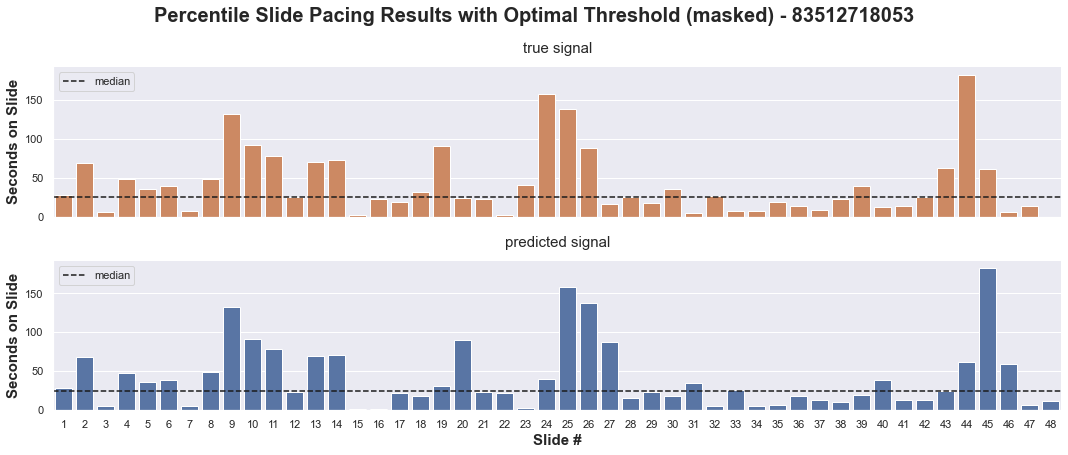

In [8]:
q = 0.9760209790209791
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type', row_order=['true', 'predicted'],
                hue='signal_type', data=pace_df.query("meeting_id == @meeting_id and (q in [None, @q]) and masked"), kind='bar', 
                dodge=False, sharex=True, sharey=True, height=3, aspect=5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=15, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=15, fontweight='bold')
g.set_xlabels('Slide #', fontsize=15, fontweight='bold')

for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left')

g.tight_layout()
plt.suptitle(f"Percentile Slide Pacing Results with Optimal Threshold (masked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');

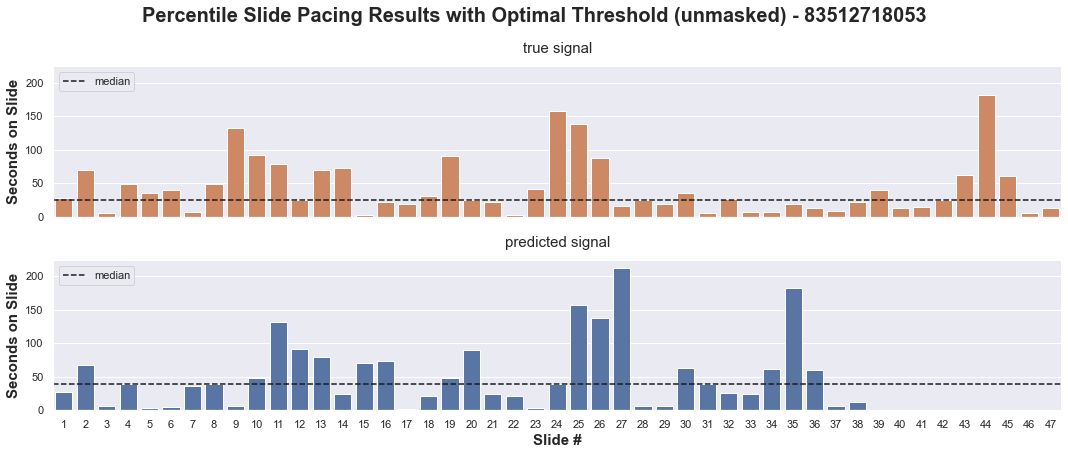

In [45]:
q = 0.981037962037962
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type', row_order=['true', 'predicted'],
                data=pace_df.query("meeting_id == @meeting_id and (signal_type == 'true' or (signal_type == 'predicted' and q == @q and not masked))"), 
                hue='signal_type', kind='bar', dodge=False, sharex=True, sharey=True, height=3, aspect=5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=15, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=15, fontweight='bold')
g.set_xlabels('Slide #', fontsize=15, fontweight='bold')

for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left')

g.tight_layout()
plt.suptitle(f"Percentile Slide Pacing Results with Optimal Threshold (unmasked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');

## HMM

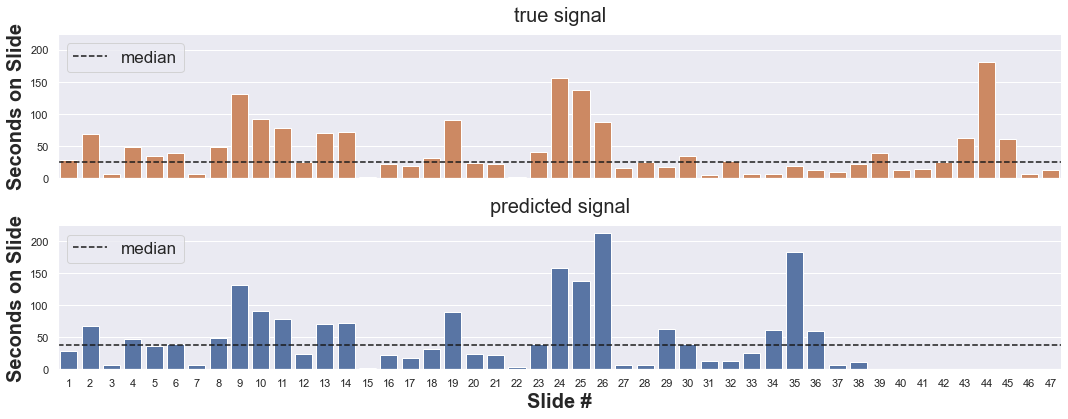

In [11]:
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type', row_order=['true', 'predicted'],
                hue='signal_type', data=hmm_pace_df.query("meeting_id == @meeting_id and masked"), kind='bar', 
                dodge=False, sharex=True, sharey=True, height=3, aspect=5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=20, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=20, fontweight='bold')
g.set_xlabels('Slide #', fontsize=20, fontweight='bold')

for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left', fontsize=17)
            
g.tight_layout()
plt.savefig("thesis/mscs_thesis/figures/3_3_1_maskedhmmpsc.pdf", dpi=300, bbox_inches='tight')
#plt.suptitle(f"HMM Slide Pacing Results (masked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');

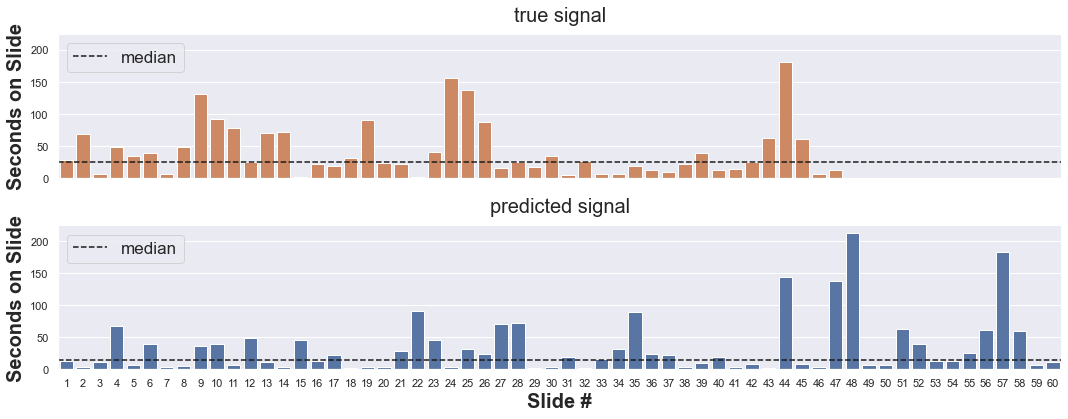

In [14]:
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type', row_order=['true', 'predicted'],
                data=hmm_pace_df.query("meeting_id == @meeting_id and (signal_type == 'true' or (signal_type == 'predicted' and not masked))"), 
                hue='signal_type', kind='bar', dodge=False, sharex=True, sharey=True, height=3, aspect=5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=20, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=20, fontweight='bold')
g.set_xlabels('Slide #', fontsize=20, fontweight='bold')

for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left', fontsize=17)
            
g.tight_layout()
plt.savefig("thesis/mscs_thesis/figures/3_3_1_unmaskedhmmpsc.pdf", dpi=300, bbox_inches='tight')
#plt.suptitle(f"HMM Slide Pacing Results (unmasked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');

# Meeting ID = 170127

In [75]:
meeting_id = 170127

## Percentile

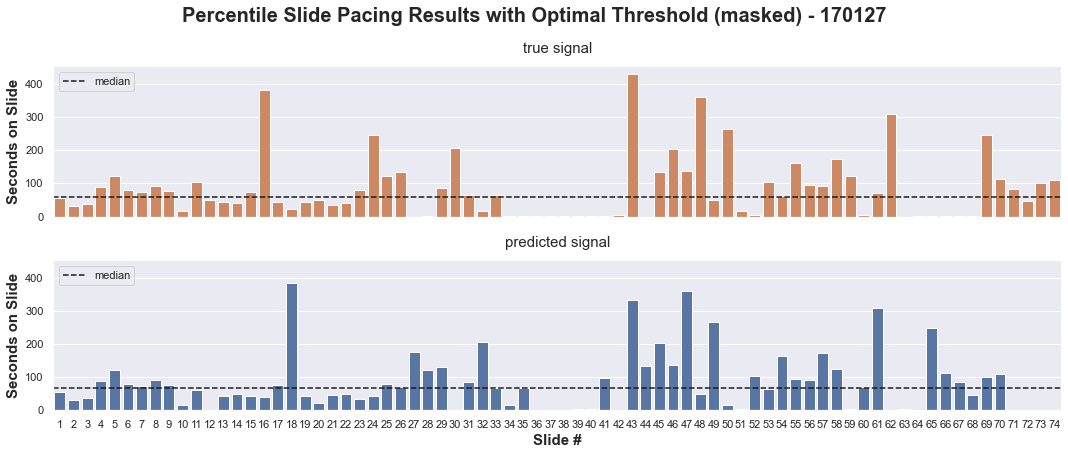

In [76]:
q = 0.9884496502358874
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type', row_order=['true', 'predicted'],
                hue='signal_type', data=pace_df.query("meeting_id == @meeting_id and (q in [None, @q]) and masked"), kind='bar', 
                dodge=False, sharex=True, sharey=True, height=3, aspect=5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=15, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=15, fontweight='bold')
g.set_xlabels('Slide #', fontsize=15, fontweight='bold')

for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left')
            
g.tight_layout()
plt.suptitle(f"Percentile Slide Pacing Results with Optimal Threshold (masked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');

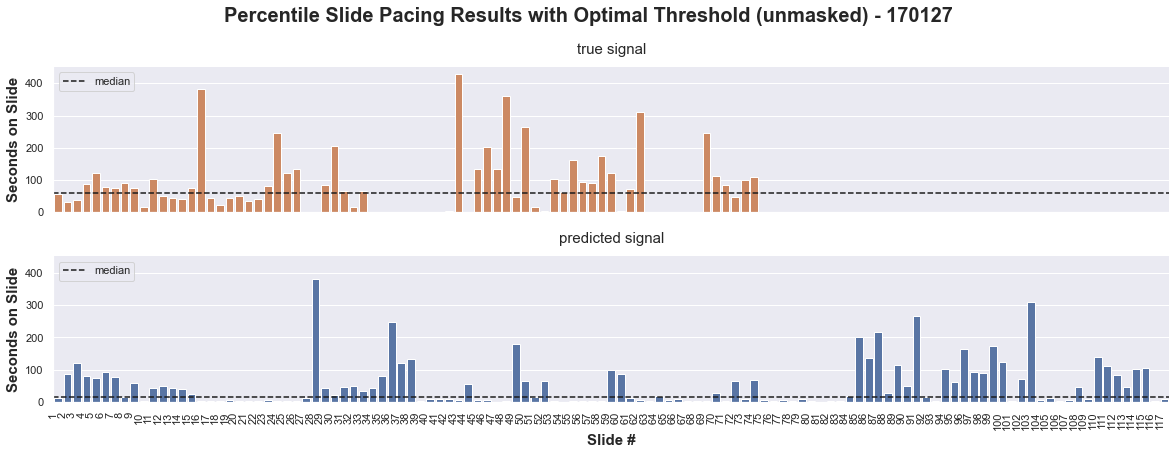

In [77]:
q = 0.9810141532454857
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type', row_order=['true', 'predicted'],
                data=pace_df.query("meeting_id == @meeting_id and (signal_type == 'true' or (signal_type == 'predicted' and q == @q and not masked))"), 
                hue='signal_type', kind='bar', dodge=False, sharex=True, sharey=True, height=3, aspect=5.5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=15, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=15, fontweight='bold')
g.set_xlabels('Slide #', fontsize=15, fontweight='bold')

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=90, 
                       horizontalalignment='right')
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left')
            
g.tight_layout()
plt.suptitle(f"Percentile Slide Pacing Results with Optimal Threshold (unmasked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');

## HMM

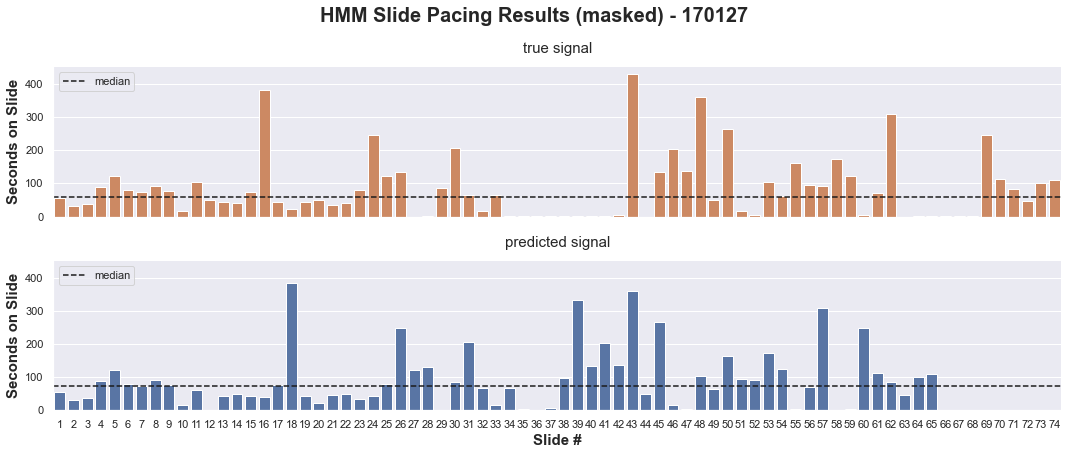

In [78]:
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type', row_order=['true', 'predicted'],
                hue='signal_type', data=hmm_pace_df.query("meeting_id == @meeting_id and masked"), kind='bar', 
                dodge=False, sharex=True, sharey=True, height=3, aspect=5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=15, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=15, fontweight='bold')
g.set_xlabels('Slide #', fontsize=15, fontweight='bold')

for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left')
            
g.tight_layout()
plt.suptitle(f"HMM Slide Pacing Results (masked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');

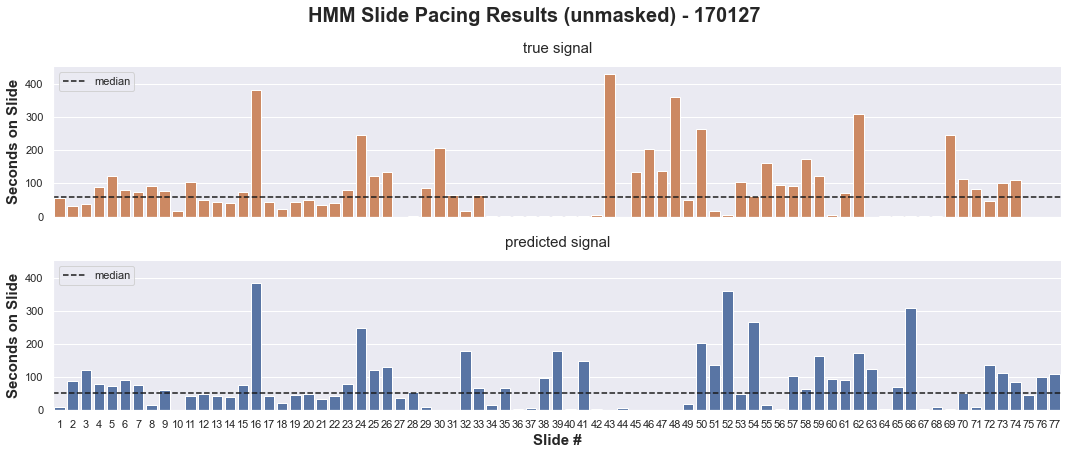

In [79]:
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type', row_order=['true', 'predicted'],
                data=hmm_pace_df.query("meeting_id == @meeting_id and (signal_type == 'true' or (signal_type == 'predicted' and not masked))"), 
                hue='signal_type', kind='bar', dodge=False, sharex=True, sharey=True, height=3, aspect=5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=15, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=15, fontweight='bold')
g.set_xlabels('Slide #', fontsize=15, fontweight='bold')

for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left')
            
g.tight_layout()
plt.suptitle(f"HMM Slide Pacing Results (unmasked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');

# Meeting ID = 89526605115

In [6]:
meeting_id = 89526605115

## HMM

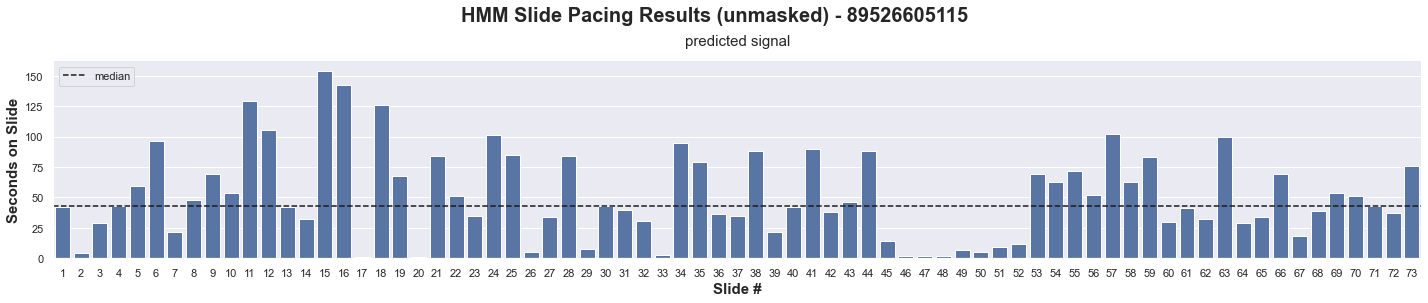

In [9]:
g = sns.catplot(x='slide_count', y='seconds_on_slide', row='signal_type',
                data=hmm_pace_df.query("meeting_id == @meeting_id and (signal_type == 'true' or (signal_type == 'predicted' and not masked))"), 
                hue='signal_type', kind='bar', dodge=False, sharex=True, sharey=True, height=4, aspect=5, estimator=np.median)
g.map_dataframe(add_median, linestyle='dashed', color='k', label='median')
g.set_titles(row_template="{row_name} signal", size=15, y=1.05)
g.set_ylabels('Seconds on Slide', fontsize=15, fontweight='bold')
g.set_xlabels('Slide #', fontsize=15, fontweight='bold')

for ax in g.axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'median':
            ax.legend([handle], [label], loc='upper left')
            
g.tight_layout()
plt.suptitle(f"HMM Slide Pacing Results (unmasked) - {meeting_id}", y=1.05, fontsize=20, fontweight='bold');